# 카메라 스티커앱
[1. 사진 준비하기](#1-사진-준비하기)   
[2. face detection](#2-face-detection)  
[3. face landmark](#3-face-landmark)   
[4. 스티커 적용하기](#4-스티커-적용하기)   
[5. 회전된 스티커 적용하기](#5-회전된-스티커-적용하기)

In [51]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


- 이미지 처리를 위해 opencv와 이미지 출력을 위해 matplotlib을 import 한다.

In [94]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

## 1. 사진 준비하기
출력을 하였는데 색상이 쫌 이상하다.   
why???) opencv 특징 때문인데 opencv는 BRG(파랑, 녹색, 빨강)순으로 사용한다.
  - matplotlib, dlib등의 이미지 라이브러리는 RGB(빨강, 녹색, 파랑)순으로 사용

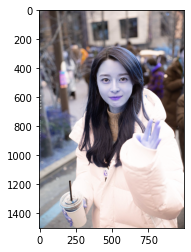

In [95]:
my_image_path = '/content/gdrive/MyDrive/AIFFEL/faceApp_pic/nara.jpeg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옴
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

## 2. face detection
### detector를 이용해서 얼굴의 bounding box를 추출
- dlib를 이용해 hog detector 선언
- `detector_hog`를 이용해서 얼굴의 bounding box 추출
- dlib은 rgb이미지를 입력으로 받아서 cvtColor()를 이용해 opencv의 bgr 이미지를 rgb로 변환
- `cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)` 반복 적용할 경우 안색이 다시 안좋아지니 한번만 사용
- 사진을 확대해도 


 색상 출력 순서를 바꿔주니 안색이 좋아졌다.

찾은 얼굴영역 좌표: rectangles[[(379, 409) (646, 676)]]


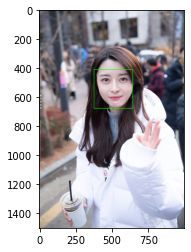

In [96]:
detector_hog = dlib.get_frontal_face_detector() # detector 선언
dlib_rects = detector_hog(img_bgr, 1) # (image, num of img pyramid)
print(f'찾은 얼굴영역 좌표: {dlib_rects}')

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. face landmark
### 랜드마크 모델 호출 후 출력
- top-down: bounding box를 찾고 box내부의 keypoint 예측
- 저장한 landmark 모델을 불러오자

- `landmark_predictor`은 `RGB 이미지`와 `dlib.rectangle`을 입력받아 `dlib.full_object_detection`을 반환

In [97]:
model_path = '/content/gdrive/MyDrive/AIFFEL/faceApp_pic/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

- `point`는 `dlib.full_object_detection`의 객체라서 `parts()`함수로 개별 위치에 접근가능
- 더 직관적인 형태로 `(p.x, p.y)`로 변환
- `list_landmark`에 68개의 랜드마크가 얼굴 개수만큼 저장

In [98]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아낸다.
for dlib_rect in dlib_rects:
  points = landmark_predictor(img_show_rgb, dlib_rect)
  # face landmark 좌표 저장
  list_point = list(map(lambda p: (p.x, p.y), points.parts()))
  list_landmarks.append(list_point)

print(len(list_landmarks[0]))

68


- 68개의 landmarks 위치는 아래와 같다.   
![landmarks](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQD7BXRMo5QRAs7Nioy6I960qw5Rzl3voeWK0_Ljpgagppv4F2zva6QSUCuS03haEtvsvI&usqp=CAU)

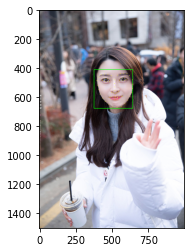

In [99]:
for landmark in list_landmarks:
  for point in landmark:
    cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 4. 스티커 적용하기


In [117]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
  print(f'코의 중심점: {landmark[30]}')
  x = landmark[30][0]
  y = landmark[30][1] - dlib_rect.height() // 2
  w = h = dlib_rect.width()
  print(f'(x, y) : ({x}, {y})')
  print(f'(w, h) : ({w}, {h})')

코의 중심점: (152, 96)
(x, y) : (152, 51)
(w, h) : (90, 90)


(90, 90, 3)


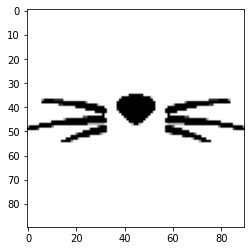

In [116]:
# sticker_path = '/content/gdrive/MyDrive/AIFFEL/faceApp_pic/king.png'
sticker_path = '/content/gdrive/MyDrive/AIFFEL/faceApp_pic/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옴
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

- 이미지 시작점인 top-left 좌표로, x, y 좌표 변경

In [102]:
refined_x = x - w // 2
refined_y = y - h // 16
print(f'(x, y) : ({refined_x}, {refined_y})')

(x, y) : (389, 404)


- 스티커 적용
- `sticker_area`는 원본이미지에 스티커를 적용할 위치를 crop한 이미지이다.
- `np.where`를 통해 `img_sticker`가 0인 부분은 `sticker_area`사용하고 0이 아닌 부분을 `img_sticker`을 사용한다.
- 때문에, `img_sticker == 0`으로 할 경우 배경인 흰색이 그대로 출력이된다.
- `img_sticker == 255`로 배경을 없애주자.

In [103]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
                        

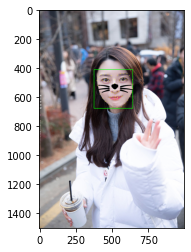

In [105]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 최종 결과 출력을 위해 `img_show` 대신 `img_bgr`을 사용한다.

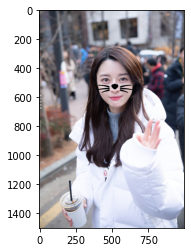

In [107]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 5. 회전된 스티커 적용하기

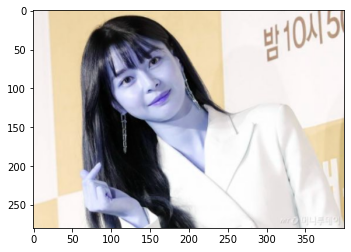


찾은 얼굴영역 좌표: rectangles[[(106, 56) (195, 146)]]


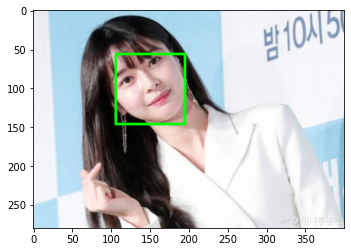

In [111]:
# 원본 이미지 불러오기
my_image_path = '/content/gdrive/MyDrive/AIFFEL/faceApp_pic/nara3.jpeg'
img_bgr = cv2.imread(my_image_path)                   # OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (400, 280))             # 640x360의 크기로 Resize
img_show = img_bgr.copy()                             # 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

detector_hog = dlib.get_frontal_face_detector()   # detector 선언 
dlib_rects = detector_hog(img_bgr, 1)   # (image, num of img pyramid)
print(f'\n찾은 얼굴영역 좌표: {dlib_rects}')

# 이미지 위에 dlib 박스 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) # plt.imshow를 RGB로 바꾸기
plt.imshow(img_show_rgb)
plt.show()

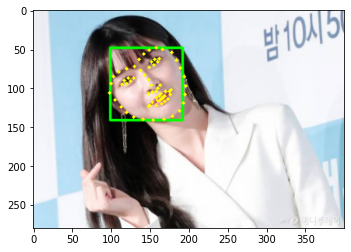

In [109]:
# landmark 모델 호출
model_path = '/content/gdrive/MyDrive/AIFFEL/faceApp_pic/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [120]:
import math

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(f'코의 중심점: {landmark[30]}')
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width() // 2
    w = h = dlib_rect.width()
    print(f'(x, y) : ({x}, {y})')
    print(f'(w, h) : ({w}, {h})')

# 회전 각 구하기
tan_theta = (landmark[30][0] - landmark[27][0]) / (landmark[30][1] - landmark[27][1])
theta = np.arctan(tan_theta)
rotate_angle = theta * 180 / math.pi
print(f'회전각: {rotate_angle}')

코의 중심점: (152, 96)
(x, y) : (152, 51)
(w, h) : (90, 90)
회전각: 36.384351815835885


(94, 94, 3)


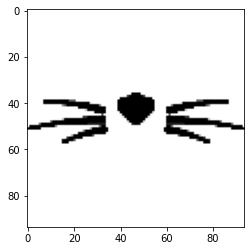

In [68]:
sticker_path = '/content/gdrive/MyDrive/AIFFEL/faceApp_pic/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옴
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

(94, 94, 3)


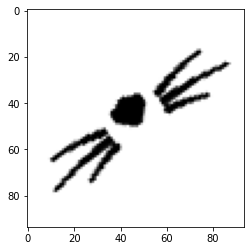

In [69]:
# 스티커 회전하기
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
  return result

img_rotate = rotate_image(img_sticker,rotate_angle)
print(img_rotate.shape)
plt.imshow(img_rotate)
plt.show()

In [70]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정 (이미지 시작점은 top-left 좌표)
refined_x = []
refined_y = []
for i in range(1):
    refined_x.append(x - w//2)  # left
    refined_y.append(y)     # top

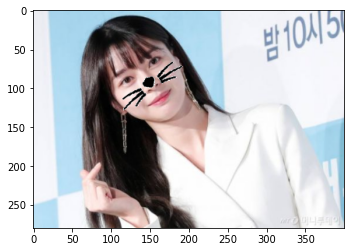

In [71]:
for i in range(1):
    sticker_area = img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]]
    img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]] = np.where(img_rotate==255,sticker_area,img_rotate).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()